## Import

In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar100
from sklearn.model_selection import train_test_split

print(f'tensorflow version : {tf.__version__}')
print(f'numpy version : {np.__version__}')

tensorflow version : 2.10.0
numpy version : 1.23.5


In [5]:
GLOBAL_BATCHSIZE = 32

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[3], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[3], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

## Data load

In [7]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=1004)

print(f'X train : {X_train.shape} shape, X valid : {X_valid.shape} shape, X test : {X_test.shape} shape')

X train : (40000, 32, 32, 3) shape, X valid : (10000, 32, 32, 3) shape, X test : (10000, 32, 32, 3) shape


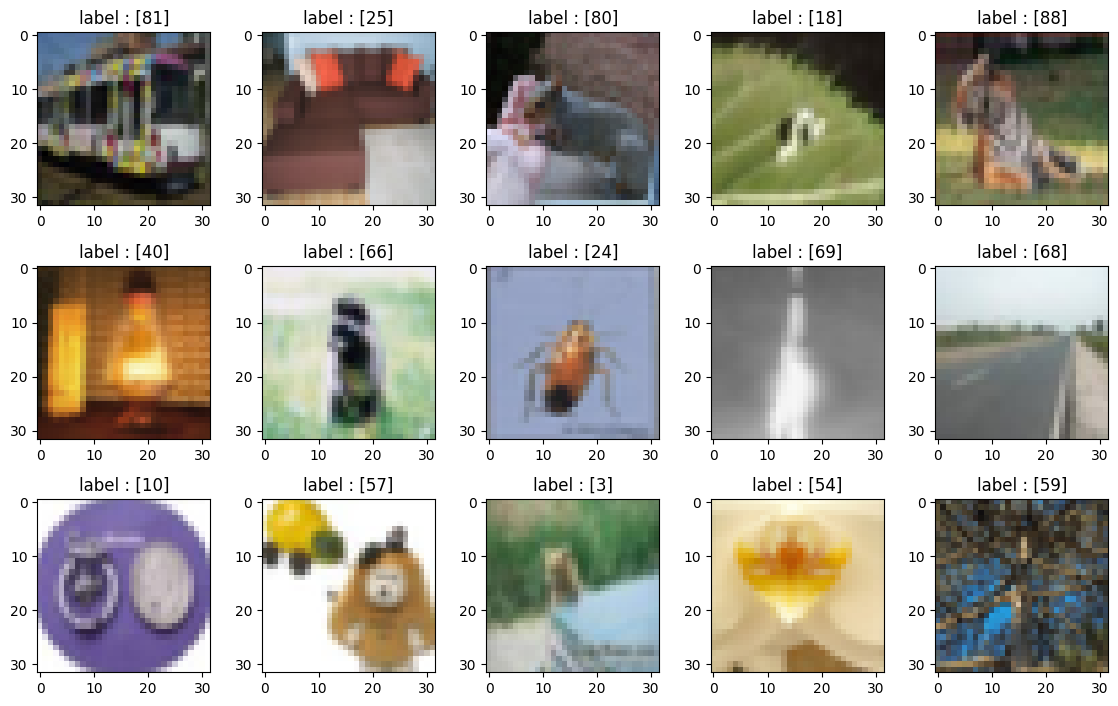

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

for i, (image, label) in enumerate(zip(X_train[:15], y_train[:15])):
    plt.subplot(3, 5, i+1)
    plt.title(f'label : {label}')
    plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)
    plt.imshow(image)

## Data augmentation

In [9]:
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

2023-11-22 02:33:14.889109: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 02:33:14.896408: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-22 02:33:14.939755: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-22 02:33:14.941061: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

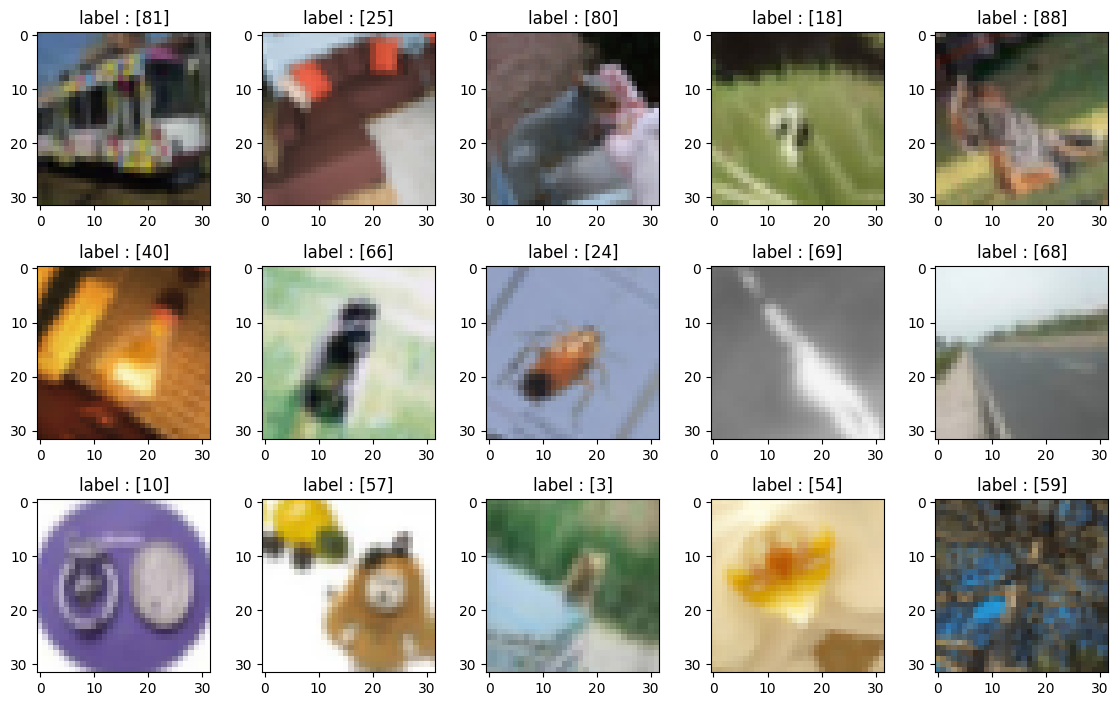

In [10]:
plt.figure(figsize=(14, 8))

for i, (image, label) in enumerate(zip(X_train[:15], y_train[:15])):
    plt.subplot(3, 5, i+1)
    plt.title(f'label : {label}')
    plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)
    augmented_image = data_augmentation(image)
    plt.imshow(tf.cast(augmented_image, dtype=tf.int32))

## Resize function

In [11]:
def parse_image(image):
    image = tf.image.resize(image, [224, 224])
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image / 255.

## Data loader

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(len(X_train))
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
train_dataset = train_dataset.map(lambda x, y: (parse_image(x), y))
train_dataset = train_dataset.batch(GLOBAL_BATCHSIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_dataset = valid_dataset.shuffle(len(X_valid))
valid_dataset = valid_dataset.map(lambda x, y: (parse_image(x), y))
valid_dataset = valid_dataset.batch(GLOBAL_BATCHSIZE)
valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

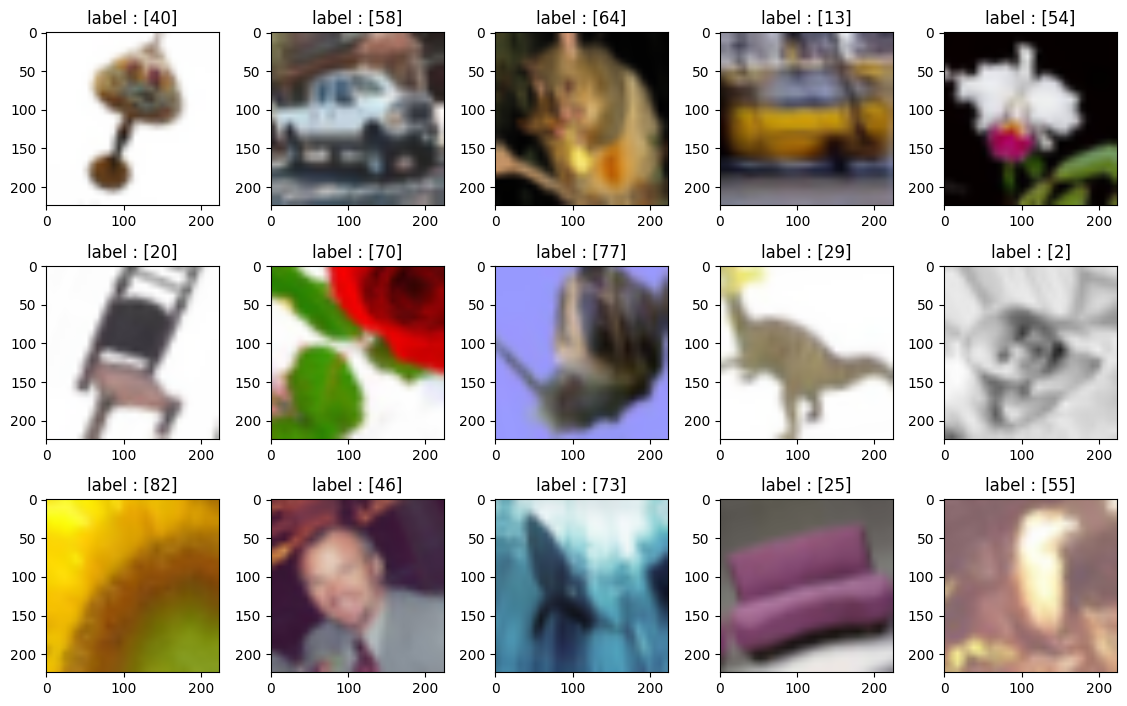

In [13]:
plt.figure(figsize=(14, 8))
for images, labels in train_dataset.take(1):
    for i, (image, label) in enumerate(zip(images[:15], labels[:15])):
        plt.subplot(3, 5, i+1)
        plt.title(f'label : {label}')
        plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)
        plt.imshow(image)

In [14]:
for i, j in train_dataset.take(1):
    print(i.shape, j.shape)

(32, 224, 224, 3) (32, 1)


## Bulid VGG

In [15]:
# Implement VGG using Sequential
def VGG_Sequential(version='vgg16', num_classes=100):
    filters = 64
    if version == 'vgg19':
        model = tf.keras.Sequential(
            [   
                # Input
                layers.Input(shape=(224, 224, 3), name='vgg_input'),
                
                # Convolutional Layers 1
                layers.Conv2D(filters, 3, 1, padding='same', activation='relu', name='conv1_1'),
                layers.Conv2D(filters, 3, 1, padding='same', activation='relu', name='conv1_2'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool1'),
                
                # Convolutional Layers 2
                layers.Conv2D(filters * 2, 3, 1, padding='same', activation='relu', name='conv2_1'),
                layers.Conv2D(filters * 2, 3, 1, padding='same', activation='relu', name='conv2_2'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool2'),
                
                # Convolutional Layers 3
                layers.Conv2D(filters * 4, 3, 1, padding='same', activation='relu', name='conv3_1'),
                layers.Conv2D(filters * 4, 3, 1, padding='same', activation='relu', name='conv3_2'),
                layers.Conv2D(filters * 4, 3, 1, padding='same', activation='relu', name='conv3_3'),
                layers.Conv2D(filters * 4, 3, 1, padding='same', activation='relu', name='conv3_4'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool3'),
                
                # Convolutional Layers 4
                layers.Conv2D(filters * 8, 3, 1, padding='same', activation='relu', name='conv4_1'),
                layers.Conv2D(filters * 8, 3, 1, padding='same', activation='relu', name='conv4_2'),
                layers.Conv2D(filters * 8, 3, 1, padding='same', activation='relu', name='conv4_3'),
                layers.Conv2D(filters * 8, 3, 1, padding='same', activation='relu', name='conv4_4'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool4'),
                
                # Convolutional Layers 5
                layers.Conv2D(filters * 8, 3, 1, padding='same', activation='relu', name='conv5_1'),
                layers.Conv2D(filters * 8, 3, 1, padding='same', activation='relu', name='conv5_2'),
                layers.Conv2D(filters * 8, 3, 1, padding='same', activation='relu', name='conv5_3'),
                layers.Conv2D(filters * 8, 3, 1, padding='same', activation='relu', name='conv5_4'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool5'),
                
                # Flatten
                layers.Flatten(name='Flatten'),
                
                # Fully Connected Layers
                layers.Dense(4096, activation='relu', name='fc1'),
                layers.Dropout(rate=0.5, name='dropout1'),
                layers.Dense(4096, activation='relu', name='fc2'),
                layers.Dropout(rate=0.5, name='dropout2'),
                
                # Classifier
                layers.Dense(num_classes, activation='softmax', name='output'),
            ]
        )
    elif version == 'vgg16':
        model = tf.keras.Sequential(
            [   
                # Input
                layers.Input(shape=(224, 224, 3), name='vgg_input'),
                
                # Convolutional Layers 1
                layers.Conv2D(filters, 3, 1, padding='same', activation='relu', name='conv1_1'),
                layers.Conv2D(filters, 3, 1, padding='same', activation='relu', name='conv1_2'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool1'),
                
                # Convolutional Layers 2
                layers.Conv2D(filters * 2, 3, 1, padding='same', activation='relu', name='conv2_1'),
                layers.Conv2D(filters * 2, 3, 1, padding='same', activation='relu', name='conv2_2'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool2'),
                
                # Convolutional Layers 3
                layers.Conv2D(filters * 4, 3, 1, padding='same', activation='relu', name='conv3_1'),
                layers.Conv2D(filters * 4, 3, 1, padding='same', activation='relu', name='conv3_2'),
                layers.Conv2D(filters * 4, 3, 1, padding='same', activation='relu', name='conv3_3'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool3'),
                
                # Convolutional Layers 4
                layers.Conv2D(filters * 8, 3, 1, padding='same', activation='relu', name='conv4_1'),
                layers.Conv2D(filters * 8, 3, 1, padding='same', activation='relu', name='conv4_2'),
                layers.Conv2D(filters * 8, 3, 1, padding='same', activation='relu', name='conv4_3'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool4'),
                
                # Convolutional Layers 5
                layers.Conv2D(filters * 8, 3, 1, padding='same', activation='relu', name='conv5_1'),
                layers.Conv2D(filters * 8, 3, 1, padding='same', activation='relu', name='conv5_2'),
                layers.Conv2D(filters * 8, 3, 1, padding='same', activation='relu', name='conv5_3'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool5'),
                
                # Flatten
                layers.Flatten(name='Flatten'),
                
                # Fully Connected Layers
                layers.Dense(4096, activation='relu', name='fc1'),
                layers.Dropout(rate=0.5, name='dropout1'),
                layers.Dense(4096, activation='relu', name='fc2'),
                layers.Dropout(rate=0.5, name='dropout2'),
                
                # Classifier
                layers.Dense(num_classes, activation='softmax', name='output'),
            ]
        )
    elif version == 'advanced_vgg19':
        model = tf.keras.Sequential(
            [   
                # Input
                layers.Input(shape=(224, 224, 3), name='vgg_input'),
                
                # Convolutional Layers 1
                layers.Conv2D(filters, 3, 1, padding='same', name='conv1_1', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.BatchNormalization(name='bn1_1'),
                layers.Activation('relu'),
                layers.Conv2D(filters, 3, 1, padding='same', name='conv1_2', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.BatchNormalization(name='bn1_2'),
                layers.Activation('relu'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool1'),
                
                # Convolutional Layers 2
                layers.Conv2D(filters * 2, 3, 1, padding='same', name='conv2_1', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.BatchNormalization(name='bn2_1'),
                layers.Activation('relu'),
                layers.Conv2D(filters * 2, 3, 1, padding='same', name='conv2_2', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.BatchNormalization(name='bn2_2'),
                layers.Activation('relu'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool2'),
                
                # Convolutional Layers 3
                layers.Conv2D(filters * 4, 3, 1, padding='same', name='conv3_1', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.BatchNormalization(name='bn3_1'),
                layers.Activation('relu'),
                layers.Conv2D(filters * 4, 3, 1, padding='same', name='conv3_2', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.BatchNormalization(name='bn3_2'),
                layers.Activation('relu'),
                layers.Conv2D(filters * 4, 3, 1, padding='same', name='conv3_3', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.BatchNormalization(name='bn3_3'),
                layers.Activation('relu'),
                layers.Conv2D(filters * 4, 3, 1, padding='same', name='conv3_4', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.BatchNormalization(name='bn3_4'),
                layers.Activation('relu'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool3'),
                
                # Convolutional Layers 4
                layers.Conv2D(filters * 8, 3, 1, padding='same', name='conv4_1', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.BatchNormalization(name='bn4_1'),
                layers.Activation('relu'),
                layers.Conv2D(filters * 8, 3, 1, padding='same', name='conv4_2', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.BatchNormalization(name='bn4_2'),
                layers.Activation('relu'),
                layers.Conv2D(filters * 8, 3, 1, padding='same', name='conv4_3', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.BatchNormalization(name='bn4_3'),
                layers.Activation('relu'),
                layers.Conv2D(filters * 8, 3, 1, padding='same', name='conv4_4', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.BatchNormalization(name='bn4_4'),
                layers.Activation('relu'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool4'),
                
                # Convolutional Layers 5
                layers.Conv2D(filters * 8, 3, 1, padding='same', name='conv5_1', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.BatchNormalization(name='bn5_1'),
                layers.Activation('relu'),
                layers.Conv2D(filters * 8, 3, 1, padding='same', name='conv5_2', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.BatchNormalization(name='bn5_2'),
                layers.Activation('relu'),
                layers.Conv2D(filters * 8, 3, 1, padding='same', name='conv5_3', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.BatchNormalization(name='bn5_3'),
                layers.Activation('relu'),
                layers.Conv2D(filters * 8, 3, 1, padding='same', name='conv5_4', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.BatchNormalization(name='bn5_4'),
                layers.Activation('relu'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool5'),
                
                # Flatten
                layers.Flatten(name='Flatten'),
                
                # Fully Connected Layers
                layers.Dense(4096, activation='relu', name='fc1', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.Dropout(rate=0.5, name='dropout1'),
                layers.Dense(4096, activation='relu', name='fc2', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.Dropout(rate=0.5, name='dropout2'),
                
                # Classifier
                layers.Dense(num_classes, activation='softmax', name='output'),
            ]
        )
    elif version == 'advanced_vgg16':
        model = tf.keras.Sequential(
            [   
                # Input
                layers.Input(shape=(224, 224, 3), name='vgg_input'),
                
                # Convolutional Layers 1
                layers.Conv2D(filters, 3, 1, padding='same', name='conv1_1', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.BatchNormalization(name='bn1_1'),
                layers.Activation('relu'),
                layers.Conv2D(filters, 3, 1, padding='same', name='conv1_2', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.BatchNormalization(name='bn1_2'),
                layers.Activation('relu'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool1'),
                
                # Convolutional Layers 2
                layers.Conv2D(filters * 2, 3, 1, padding='same', name='conv2_1', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.BatchNormalization(name='bn2_1'),
                layers.Activation('relu'),
                layers.Conv2D(filters * 2, 3, 1, padding='same', name='conv2_2', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.BatchNormalization(name='bn2_2'),
                layers.Activation('relu'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool2'),
                
                # Convolutional Layers 3
                layers.Conv2D(filters * 4, 3, 1, padding='same', name='conv3_1', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.BatchNormalization(name='bn3_1'),
                layers.Activation('relu'),
                layers.Conv2D(filters * 4, 3, 1, padding='same', name='conv3_2', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.BatchNormalization(name='bn3_2'),
                layers.Activation('relu'),
                layers.Conv2D(filters * 4, 3, 1, padding='same', name='conv3_3', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.BatchNormalization(name='bn3_3'),
                layers.Activation('relu'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool3'),
                
                # Convolutional Layers 4
                layers.Conv2D(filters * 8, 3, 1, padding='same', name='conv4_1', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.BatchNormalization(name='bn4_1'),
                layers.Activation('relu'),
                layers.Conv2D(filters * 8, 3, 1, padding='same', name='conv4_2', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.BatchNormalization(name='bn4_2'),
                layers.Activation('relu'),
                layers.Conv2D(filters * 8, 3, 1, padding='same', name='conv4_3', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.BatchNormalization(name='bn4_3'),
                layers.Activation('relu'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool4'),
                
                # Convolutional Layers 5
                layers.Conv2D(filters * 8, 3, 1, padding='same', name='conv5_1', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.BatchNormalization(name='bn5_1'),
                layers.Activation('relu'),
                layers.Conv2D(filters * 8, 3, 1, padding='same', name='conv5_2', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.BatchNormalization(name='bn5_2'),
                layers.Activation('relu'),
                layers.Conv2D(filters * 8, 3, 1, padding='same', name='conv5_3', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.BatchNormalization(name='bn5_3'),
                layers.Activation('relu'),
                layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool5'),
                
                # Flatten
                layers.Flatten(name='Flatten'),
                
                # Fully Connected Layers
                layers.Dense(4096, activation='relu', name='fc1', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.Dropout(rate=0.5, name='dropout1'),
                layers.Dense(4096, activation='relu', name='fc2', kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
                layers.Dropout(rate=0.5, name='dropout2'),
                
                # Classifier
                layers.Dense(num_classes, activation='softmax', name='output'),
            ]
        )
    
    return model

In [16]:
# build model (version vgg16, vgg19, advanced_vgg16, advanced_vgg19)
model = VGG_Sequential('advanced_vgg16', num_classes=100)

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 bn1_1 (BatchNormalization)  (None, 224, 224, 64)      256       
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 bn1_2 (BatchNormalization)  (None, 224, 224, 64)      256       
                                                                 
 activation_1 (Activation)   (None, 224, 224, 64)      0         
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)     

## Training

In [18]:
# Define callbacks
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=2, mode='min',restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.00001)] 

# Define model
model = VGG_Sequential('advanced_vgg16', num_classes=100)

# compile
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(False),
    metrics=["accuracy"],
)

# training
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=valid_dataset,
                    callbacks=callbacks_list
                    )

Epoch 1/50


2023-11-22 02:33:25.630197: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1250/1250 [==============================] - 240s 187ms/step - loss: 6.5835 - accuracy: 0.0100 - val_loss: 6.1947 - val_accuracy: 0.0179 - lr: 0.0100
Epoch 2/50
1250/1250 [==============================] - 228s 182ms/step - loss: 6.1969 - accuracy: 0.0105 - val_loss: 6.1140 - val_accuracy: 0.0176 - lr: 0.0100
Epoch 3/50
1250/1250 [==============================] - 226s 181ms/step - loss: 6.1183 - accuracy: 0.0089 - val_loss: 6.0796 - val_accuracy: 0.0100 - lr: 0.0100
Epoch 4/50
1250/1250 [==============================] - 226s 181ms/step - loss: 6.0456 - accuracy: 0.0092 - val_loss: 6.0079 - val_accuracy: 0.0100 - lr: 0.0100
Epoch 5/50
1250/1250 [==============================] - 226s 181ms/step - loss: 5.9746 - accuracy: 0.0097 - val_loss: 5.9251 - val_accuracy: 0.0151 - lr: 0.0100
Epoch 6/50
1250/1250 [==============================] - 227s 181ms/step - loss: 5.9065 - accuracy: 0.0106 - val_loss: 5.8757 - val_accuracy: 0.0100 - lr: 0.0100
Epoch 7/50
1250/1250 [=======================

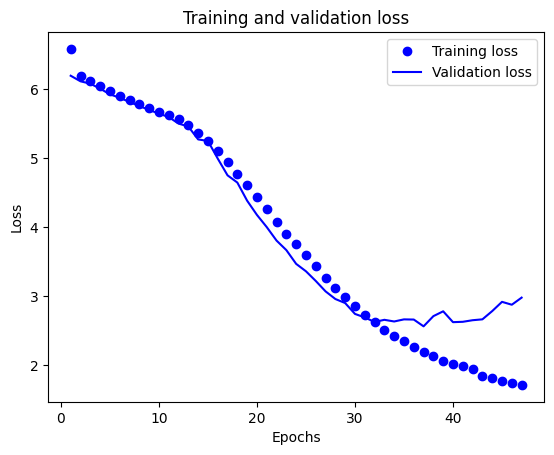

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

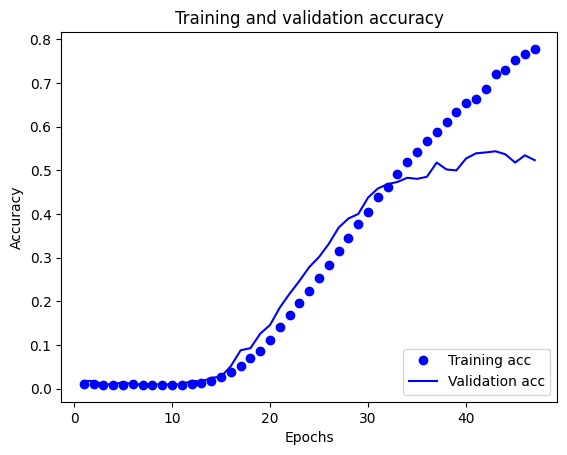

In [27]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## Evaluation

In [30]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.shuffle(len(X_test))
test_dataset = test_dataset.map(lambda x, y: (parse_image(x), y))
test_dataset = test_dataset.batch(1)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

preds, labels = [], []
for image, label in test_dataset:
    pred = model.predict(image, verbose=0)
    preds.append(pred)
    labels.append(label)

In [36]:
from sklearn.metrics import f1_score

f1_score(np.squeeze(labels), np.argmax(preds, axis=-1).reshape(-1), average='weighted')

0.5169375283776104